In [1]:
# using Pkg
# Pkg.add("JLD2")
# Pkg.add("FileIO")

In [2]:
using LinearAlgebra
using PyPlot
using Random
using Statistics
using Printf
using JLD2, FileIO
using ProgressMeter
using Base.Threads
include("ILearning.jl");
rng = MersenneTwister(1234);

In [3]:
function Storkey1(U,Win=nothing)
    row, col = size(U)
    if Win==nothing
        W = zeros(Complex, row,row)
    else
        W = copy(Win)
    end
    
    for i = 1:col
        u = U[:,i]
        h = W*u
        W += (u*u' - u*h' - h*u')/row
    end
    return W
end
    
function Storkey2(U,Win=nothing)
    row, col = size(U)
    if Win==nothing
        W = zeros(Complex, row,row)
    else
        W = copy(Win)
    end
    
    for i = 1:col
        u = U[:,i]
        h = W*u
        W += ((u-h)*(u-h)')/row
#         println(norm(W))
    end
    return W
end

Storkey2 (generic function with 2 methods)

In [4]:
N = 100;

### Number of Simulations
Nsim = 300

DeltaP = 2

Pv = range(1,120,step = DeltaP);

### Noise Level Vector
pr = 0.0

Pv

1:2:119

## Multistate CvHNN, K=8

In [4]:
### Number of maximum iterations for the HNN model
it_max = 1

### Estados Possiveis
K = 8
MultiStates = exp.(2*pi*collect(0:K-1)*im/K);

## Check if one fundamental memory, picked at random, is a fixed point!

In [6]:
Success = zeros(Int64,(4,length(Pv)));

@showprogress for s = 1:Nsim
    # The first fundamental memory;
    Uall = rand(rng,MultiStates,(N,1))
    
    W = [zeros(Complex,N,N) for i=1:4];
#     W[1] = ILearning.train(ILearning.first,u1)
    W[1]= Storkey1(Uall)
#     W[2] = ILearning.train(ILearning.second,u1)
    W[2] = Storkey2(Uall)
    W[3] = ILearning.Correlation(Uall);
    W[4], A = ILearning.Projection(Uall);
      
    @threads for i=1:4
        Wm = W[i] - Diagonal(Diagonal(W[i]))    
        y = ILearning.Asy(Wm,Uall,ILearning.csign,K,it_max)
        if sum(abs.(Uall-y))<1.e-4
            Success[i,1] = Success[i,1] + 1
        end
    end
    
    for j=2:length(Pv)
        
        U = rand(rng,MultiStates,(N,DeltaP))
        Uall = hcat(Uall,U)

#         W[1] = ILearning.train(ILearning.first,U,W[1])
        W[1] = Storkey1(U,W[1])
#         W[2] = ILearning.train(ILearning.second,U,W[2])
        W[2] = Storkey2(U,W[2])
        W[3] = ILearning.Correlation(U,W[3]);
        W[4], A = ILearning.Projection(U,W[4],A)
        
        xi = rand(rng,1:size(Uall,2),1);
        
        @threads for i=1:4
            Wm = W[i] - Diagonal(Diagonal(W[i]))
            
            y = ILearning.Asy(Wm,Uall[:,xi],ILearning.csign,K,it_max)
            Error = sum(abs.(Uall[:,xi]-y))
            
            if Error<1.e-4
                Success[i,j] = Success[i,j] + 1
            end
        end
    end
    
    @save "JLDs/StorageCapacity_Multistate_K8.jld2" Success Nsim Pv 
end

Progress: 100%|█████████████████████████████████████████| Time: 0:08:45


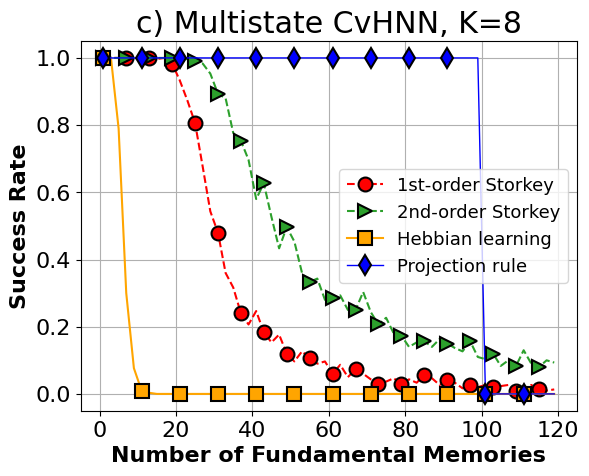

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [6]:
@load "JLDs/StorageCapacity_Multistate_K8.jld2"
rcParams = PyPlot.PyDict(PyPlot.matplotlib."rcParams")
font0 = Dict(
        "font.size" => 18,
        "axes.labelweight" => "bold",
        "axes.labelsize" => 16,
        "xtick.labelsize" => 16,
        "ytick.labelsize" => 16,
        "legend.fontsize" => 13,
)
merge!(rcParams, font0)
plot(Pv,Success[1,:]/Nsim,linewidth=1.5,color="red",linestyle ="dashed", marker="o",markersize = 10,
    markevery=3,markeredgewidth=1.5, markeredgecolor=(0,0,0),label = "1st-order Storkey")

plot(Pv,Success[2,:]/Nsim,color="#2ca02c",linestyle ="dashed", marker=">",markersize = 10,
    markevery=3,markeredgewidth=1.5, markeredgecolor=(0,0,0),label = "2nd-order Storkey")

plot(Pv,Success[3,:]/Nsim,color="orange",linestyle ="solid", marker="s",markersize = 10,
    markevery=5,markeredgewidth=1.5, markeredgecolor=(0,0,0),label = "Hebbian learning")

plot(Pv,Success[4,:]/Nsim,linewidth=1,color="blue",linestyle ="solid",markersize = 10,
    markevery=5,markeredgewidth=1.5, markeredgecolor=(0,0,0), marker="d",label = "Projection rule")

legend()
grid()

xlabel("Number of Fundamental Memories")
ylabel("Success Rate")
title("c) Multistate CvHNN, K=8")

savefig("Figures/StorageCapacity_Multistate_K8.eps",bbox_inches="tight")
savefig("Figures/StorageCapacity_Multistate_K8.pdf",bbox_inches="tight")

In [7]:
[maximum(Pv[Success[i,:].>=300*0.99]) for i=1:4]

4-element Array{Int64,1}:
 17
 25
  3
 99

## Multistate CvHNN, K = 4

In [8]:
### Number of maximum iterations for the HNN model
it_max =1

### Estados Possiveis
K = 4
MultiStates = exp.(2*pi*collect(0:K-1)*im/K)

4-element Array{Complex{Float64},1}:
                     1.0 + 0.0im
   6.123233995736766e-17 + 1.0im
                    -1.0 + 1.2246467991473532e-16im
 -1.8369701987210297e-16 - 1.0im

In [9]:
Success = zeros(Int64,(4,length(Pv)));

@showprogress for s = 1:Nsim
    # The first fundamental memory;
    Uall = rand(rng,MultiStates,(N,1))
    
    W = [zeros(Complex,N,N) for i=1:4];
#     W[1] = ILearning.train(ILearning.first,u1)
    W[1]= Storkey1(Uall)
#     W[2] = ILearning.train(ILearning.second,u1)
    W[2] = Storkey2(Uall)
    W[3] = ILearning.Correlation(Uall);
    W[4], A = ILearning.Projection(Uall);
      
    @threads for i=1:4
        Wm = W[i] - Diagonal(Diagonal(W[i]))    
        y = ILearning.Asy(Wm,Uall,ILearning.csign,K,it_max)
        if sum(abs.(Uall-y))<1.e-4
            Success[i,1] = Success[i,1] + 1
        end
    end
    
    for j=2:length(Pv)
        
        U = rand(rng,MultiStates,(N,DeltaP))
        Uall = hcat(Uall,U)

#         W[1] = ILearning.train(ILearning.first,U,W[1])
        W[1] = Storkey1(U,W[1])
#         W[2] = ILearning.train(ILearning.second,U,W[2])
        W[2] = Storkey2(U,W[2])
        W[3] = ILearning.Correlation(U,W[3]);
        W[4], A = ILearning.Projection(U,W[4],A)
        
        xi = rand(rng,1:size(Uall,2),1);
        
        @threads for i=1:4
            Wm = W[i] - Diagonal(Diagonal(W[i]))
            
            y = ILearning.Asy(Wm,Uall[:,xi],ILearning.csign,K,it_max)
            Error = sum(abs.(Uall[:,xi]-y))
            
            if Error<1.e-4
                Success[i,j] = Success[i,j] + 1
            end
        end
    end
    
    @save "JLDs/StorageCapacity_Multistate_K4.jld2" Success Nsim Pv 
end

Progress: 100%|█████████████████████████████████████████| Time: 0:05:10


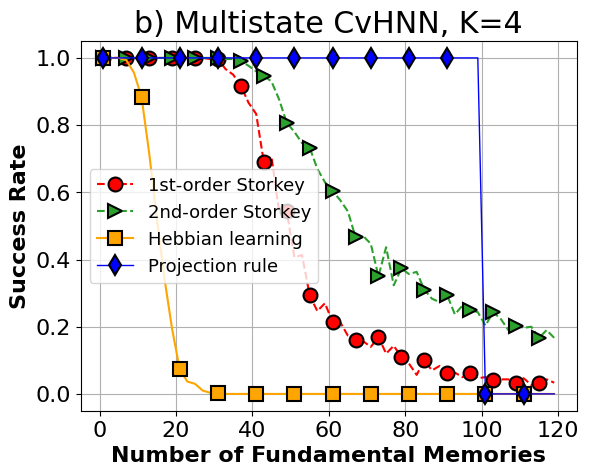

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [16]:
@load "JLDs/StorageCapacity_Multistate_K4.jld2"
rcParams = PyPlot.PyDict(PyPlot.matplotlib."rcParams")
font0 = Dict(
        "font.size" => 18,
        "axes.labelweight" => "bold",
        "axes.labelsize" => 16,
        "xtick.labelsize" => 16,
        "ytick.labelsize" => 16,
        "legend.fontsize" => 13,
)
merge!(rcParams, font0)
plot(Pv,Success[1,:]/Nsim,linewidth=1.5,color="red",linestyle ="dashed", marker="o",markersize = 10,
    markevery=3,markeredgewidth=1.5, markeredgecolor=(0,0,0),label = "1st-order Storkey")

plot(Pv,Success[2,:]/Nsim,color="#2ca02c",linestyle ="dashed", marker=">",markersize = 10,
    markevery=3,markeredgewidth=1.5, markeredgecolor=(0,0,0),label = "2nd-order Storkey")

plot(Pv,Success[3,:]/Nsim,color="orange",linestyle ="solid", marker="s",markersize = 10,
    markevery=5,markeredgewidth=1.5, markeredgecolor=(0,0,0),label = "Hebbian learning")

plot(Pv,Success[4,:]/Nsim,linewidth=1,color="blue",linestyle ="solid",markersize = 10,
    markevery=5,markeredgewidth=1.5, markeredgecolor=(0,0,0), marker="d",label = "Projection rule")

legend()
grid()

xlabel("Number of Fundamental Memories")
ylabel("Success Rate")
title("b) Multistate CvHNN, K=4")

savefig("Figures/StorageCapacity_Multistate_K4.eps",bbox_inches="tight")
savefig("Figures/StorageCapacity_Multistate_K4.pdf",bbox_inches="tight")

In [17]:
[maximum(Pv[Success[i,:].>=300*0.99]) for i=1:4]

4-element Array{Int64,1}:
 31
 37
  7
 99

## Multistate CvHNN, K = 2

In [11]:
### Number of maximum iterations for the HNN model
it_max =1

### Estados Possiveis
K = 2
MultiStates = exp.(2*pi*collect(0:K-1)*im/K)

2-element Array{Complex{Float64},1}:
  1.0 + 0.0im
 -1.0 + 1.2246467991473532e-16im

In [12]:
Success = zeros(Int64,(4,length(Pv)));

@showprogress for s = 1:Nsim
    # The first fundamental memory;
    Uall = rand(rng,MultiStates,(N,1))
    
    W = [zeros(Complex,N,N) for i=1:4];
#     W[1] = ILearning.train(ILearning.first,u1)
    W[1]= Storkey1(Uall)
#     W[2] = ILearning.train(ILearning.second,u1)
    W[2] = Storkey2(Uall)
    W[3] = ILearning.Correlation(Uall);
    W[4], A = ILearning.Projection(Uall);
      
    @threads for i=1:4
        Wm = W[i] - Diagonal(Diagonal(W[i]))    
        y = ILearning.Asy(Wm,Uall,ILearning.csign,K,it_max)
        if sum(abs.(Uall-y))<1.e-4
            Success[i,1] = Success[i,1] + 1
        end
    end
    
    for j=2:length(Pv)
        
        U = rand(rng,MultiStates,(N,DeltaP))
        Uall = hcat(Uall,U)

#         W[1] = ILearning.train(ILearning.first,U,W[1])
        W[1] = Storkey1(U,W[1])
#         W[2] = ILearning.train(ILearning.second,U,W[2])
        W[2] = Storkey2(U,W[2])
        W[3] = ILearning.Correlation(U,W[3]);
        W[4], A = ILearning.Projection(U,W[4],A)
        
        xi = rand(rng,1:size(Uall,2),1);
        
        @threads for i=1:4
            Wm = W[i] - Diagonal(Diagonal(W[i]))
            
            y = ILearning.Asy(Wm,Uall[:,xi],ILearning.csign,K,it_max)
            Error = sum(abs.(Uall[:,xi]-y))
            
            if Error<1.e-4
                Success[i,j] = Success[i,j] + 1
            end
        end
    end
    
    @save "JLDs/StorageCapacity_Multistate_K2.jld2" Success Nsim Pv 
end

Progress: 100%|█████████████████████████████████████████| Time: 0:05:33


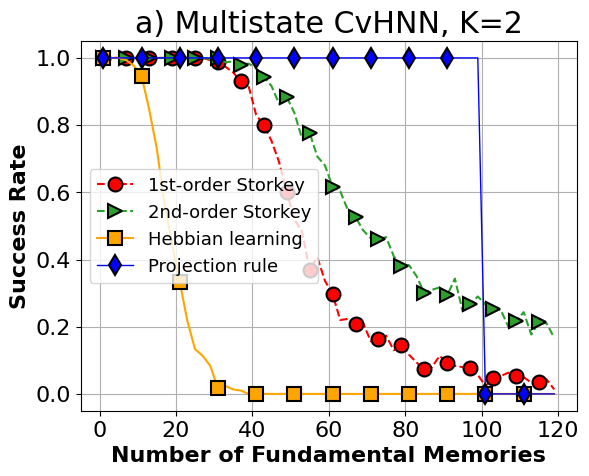

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [13]:
@load "JLDs/StorageCapacity_Multistate_K2.jld2"
rcParams = PyPlot.PyDict(PyPlot.matplotlib."rcParams")
font0 = Dict(
        "font.size" => 18,
        "axes.labelweight" => "bold",
        "axes.labelsize" => 16,
        "xtick.labelsize" => 16,
        "ytick.labelsize" => 16,
        "legend.fontsize" => 13,
)
merge!(rcParams, font0)
plot(Pv,Success[1,:]/Nsim,linewidth=1.5,color="red",linestyle ="dashed", marker="o",markersize = 10,
    markevery=3,markeredgewidth=1.5, markeredgecolor=(0,0,0),label = "1st-order Storkey")

plot(Pv,Success[2,:]/Nsim,color="#2ca02c",linestyle ="dashed", marker=">",markersize = 10,
    markevery=3,markeredgewidth=1.5, markeredgecolor=(0,0,0),label = "2nd-order Storkey")

plot(Pv,Success[3,:]/Nsim,color="orange",linestyle ="solid", marker="s",markersize = 10,
    markevery=5,markeredgewidth=1.5, markeredgecolor=(0,0,0),label = "Hebbian learning")

plot(Pv,Success[4,:]/Nsim,linewidth=1,color="blue",linestyle ="solid",markersize = 10,
    markevery=5,markeredgewidth=1.5, markeredgecolor=(0,0,0), marker="d",label = "Projection rule")

legend()
grid()

xlabel("Number of Fundamental Memories")
ylabel("Success Rate")
title("a) Multistate CvHNN, K=2")

savefig("Figures/StorageCapacity_Multistate_K2.eps",bbox_inches="tight")
savefig("Figures/StorageCapacity_Multistate_K2.pdf",bbox_inches="tight")

In [15]:
[maximum(Pv[Success[i,:].>=300*0.99]) for i=1:4]

4-element Array{Int64,1}:
 29
 35
  7
 99

## Multistate CvHNN, K = 32

In [18]:
### Number of maximum iterations for the HNN model
it_max =1

### Estados Possiveis
K = 32
MultiStates = exp.(2*pi*collect(0:K-1)*im/K)

32-element Array{Complex{Float64},1}:
                     1.0 + 0.0im
      0.9807852804032304 + 0.19509032201612825im
      0.9238795325112867 + 0.3826834323650898im
      0.8314696123025452 + 0.5555702330196022im
      0.7071067811865476 + 0.7071067811865475im
      0.5555702330196023 + 0.8314696123025452im
     0.38268343236508984 + 0.9238795325112867im
     0.19509032201612833 + 0.9807852804032304im
   6.123233995736766e-17 + 1.0im
     -0.1950903220161282 + 0.9807852804032304im
     -0.3826834323650897 + 0.9238795325112867im
      -0.555570233019602 + 0.8314696123025453im
     -0.7071067811865475 + 0.7071067811865476im
                         ⋮
     -0.7071067811865477 - 0.7071067811865475im
     -0.5555702330196022 - 0.8314696123025452im
    -0.38268343236509034 - 0.9238795325112865im
    -0.19509032201612866 - 0.9807852804032303im
 -1.8369701987210297e-16 - 1.0im
      0.1950903220161283 - 0.9807852804032304im
        0.38268343236509 - 0.9238795325112866im
      0.55557023301

In [ ]:
Success = zeros(Int64,(4,length(Pv)));

@showprogress for s = 1:Nsim
    # The first fundamental memory;
    Uall = rand(rng,MultiStates,(N,1))
    
    W = [zeros(Complex,N,N) for i=1:4];
#     W[1] = ILearning.train(ILearning.first,u1)
    W[1]= Storkey1(Uall)
#     W[2] = ILearning.train(ILearning.second,u1)
    W[2] = Storkey2(Uall)
    W[3] = ILearning.Correlation(Uall);
    W[4], A = ILearning.Projection(Uall);
      
    @threads for i=1:4
        Wm = W[i] - Diagonal(Diagonal(W[i]))    
        y = ILearning.Asy(Wm,Uall,ILearning.csign,K,it_max)
        if sum(abs.(Uall-y))<1.e-4
            Success[i,1] = Success[i,1] + 1
        end
    end
    
    for j=2:length(Pv)
        
        U = rand(rng,MultiStates,(N,DeltaP))
        Uall = hcat(Uall,U)

#         W[1] = ILearning.train(ILearning.first,U,W[1])
        W[1] = Storkey1(U,W[1])
#         W[2] = ILearning.train(ILearning.second,U,W[2])
        W[2] = Storkey2(U,W[2])
        W[3] = ILearning.Correlation(U,W[3]);
        W[4], A = ILearning.Projection(U,W[4],A)
        
        xi = rand(rng,1:size(Uall,2),1);
        
        @threads for i=1:4
            Wm = W[i] - Diagonal(Diagonal(W[i]))
            
            y = ILearning.Asy(Wm,Uall[:,xi],ILearning.csign,K,it_max)
            Error = sum(abs.(Uall[:,xi]-y))
            
            if Error<1.e-4
                Success[i,j] = Success[i,j] + 1
            end
        end
    end
    
    @save "JLDs/StorageCapacity_Multistate_K32.jld2" Success Nsim Pv 
end

Progress:  82%|█████████████████████████████████▊       |  ETA: 0:00:59

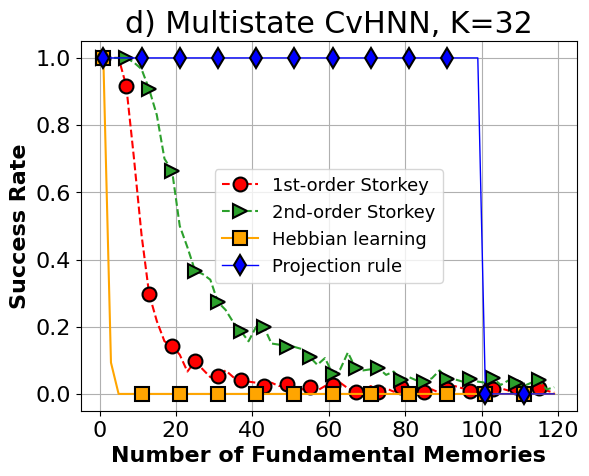

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [31]:
@load "JLDs/StorageCapacity_Multistate_K32.jld2"
rcParams = PyPlot.PyDict(PyPlot.matplotlib."rcParams")
font0 = Dict(
        "font.size" => 18,
        "axes.labelweight" => "bold",
        "axes.labelsize" => 16,
        "xtick.labelsize" => 16,
        "ytick.labelsize" => 16,
        "legend.fontsize" => 13,
)
merge!(rcParams, font0)
plot(Pv,Success[1,:]/Nsim,linewidth=1.5,color="red",linestyle ="dashed", marker="o",markersize = 10,
    markevery=3,markeredgewidth=1.5, markeredgecolor=(0,0,0),label = "1st-order Storkey")

plot(Pv,Success[2,:]/Nsim,color="#2ca02c",linestyle ="dashed", marker=">",markersize = 10,
    markevery=3,markeredgewidth=1.5, markeredgecolor=(0,0,0),label = "2nd-order Storkey")

plot(Pv,Success[3,:]/Nsim,color="orange",linestyle ="solid", marker="s",markersize = 10,
    markevery=5,markeredgewidth=1.5, markeredgecolor=(0,0,0),label = "Hebbian learning")

plot(Pv,Success[4,:]/Nsim,linewidth=1,color="blue",linestyle ="solid",markersize = 10,
    markevery=5,markeredgewidth=1.5, markeredgecolor=(0,0,0), marker="d",label = "Projection rule")

legend()
grid()

xlabel("Number of Fundamental Memories")
ylabel("Success Rate")
title("d) Multistate CvHNN, K=32")

savefig("Figures/StorageCapacity_Multistate_K32.eps",bbox_inches="tight")
savefig("Figures/StorageCapacity_Multistate_K32.pdf",bbox_inches="tight")

In [33]:
[maximum(Pv[Success[i,:].>=300*0.99]) for i=1:4]

4-element Array{Int64,1}:
  5
  7
  1
 99

## Storage Capacity by the Resolution Factor

In [5]:
N = 100;

### Number of maximum iterations for the HNN model
it_max =1

### Number of Simulations
NsimK = 10
NsimP = 300

DeltaK = 1
Kv = range(2,32,step=DeltaK);

DeltaP = 2
Pv = range(1,40,step = DeltaP);

In [8]:
EstStorage = zeros(Int,4,length(Kv))

@showprogress for sk = 1:NsimK
    for l = 1:length(Kv)

        ### Estados Possiveis
        K = Kv[l]
        MultiStates = exp.(2*pi*collect(0:K-1)*im/K)
        Success = zeros(Int64,(3,length(Pv)));
    
        for sp = 1:NsimP
            # The first fundamental memory;
            Uall = rand(rng,MultiStates,(N,1))
    
            W = [zeros(Complex,N,N) for i=1:4];
            W[1]= Storkey1(Uall)
            W[2] = Storkey2(Uall)
            W[3] = ILearning.Correlation(Uall);
#             W[4], A = ILearning.Projection(Uall);
      
            @threads for i=1:3
                Wm = W[i] - Diagonal(Diagonal(W[i]))    
                y = ILearning.Asy(Wm,Uall,ILearning.csign,K,it_max)
                if sum(abs.(Uall-y))<1.e-4
                    Success[i,1] = Success[i,1] + 1
                end
            end
    
            for j=2:length(Pv)
        
                U = rand(rng,MultiStates,(N,DeltaP))
                Uall = hcat(Uall,U)

                W[1] = Storkey1(U,W[1])
                W[2] = Storkey2(U,W[2])
                W[3] = ILearning.Correlation(U,W[3]);
#                 W[4], A = ILearning.Projection(U,W[4],A)

                xi = rand(rng,1:size(Uall,2),1);

                @threads for i=1:3
                    Wm = W[i] - Diagonal(Diagonal(W[i]))

                    y = ILearning.Asy(Wm,Uall[:,xi],ILearning.csign,K,it_max)
                    Error = sum(abs.(Uall[:,xi]-y))

                    if Error<1.e-4
                        Success[i,j] = Success[i,j] + 1
                    end
                end
            end
        end
        for i=1:3
            EstStorage[i,l] += maximum(Pv[Success[i,:].>=NsimP*0.99])
        end
        @save "JLDs/StorageCapacity_Multistate_Resolution.jld2" EstStorage NsimP Kv
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 2:44:10


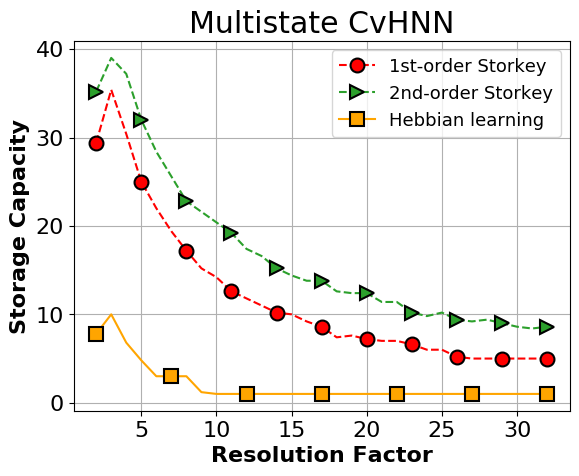

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [10]:
@load "JLDs/StorageCapacity_Multistate_Resolution.jld2"
rcParams = PyPlot.PyDict(PyPlot.matplotlib."rcParams")
font0 = Dict(
        "font.size" => 18,
        "axes.labelweight" => "bold",
        "axes.labelsize" => 16,
        "xtick.labelsize" => 16,
        "ytick.labelsize" => 16,
        "legend.fontsize" => 13,
)
merge!(rcParams, font0)

plot(Kv,EstStorage[1,:]/NsimK,linewidth=1.5,color="red",linestyle ="dashed", marker="o",markersize = 10,
    markevery=3,markeredgewidth=1.5, markeredgecolor=(0,0,0),label = "1st-order Storkey")

plot(Kv,EstStorage[2,:]/NsimK,color="#2ca02c",linestyle ="dashed", marker=">",markersize = 10,
    markevery=3,markeredgewidth=1.5, markeredgecolor=(0,0,0),label = "2nd-order Storkey")

plot(Kv,EstStorage[3,:]/NsimK,color="orange",linestyle ="solid", marker="s",markersize = 10,
    markevery=5,markeredgewidth=1.5, markeredgecolor=(0,0,0),label = "Hebbian learning")

# plot(Kv,EstStorage[4,:]/NsimK,linewidth=1,color="blue",linestyle ="solid",markersize = 10,
#     markevery=5,markeredgewidth=1.5, markeredgecolor=(0,0,0), marker="d",label = "Projection rule")

legend()
grid()

xlabel("Resolution Factor")
ylabel("Storage Capacity")
title("Multistate CvHNN")

savefig("Figures/StorageCapacity_by_Resolution.eps",bbox_inches="tight")
savefig("Figures/StorageCapacity_by_Resolution.pdf",bbox_inches="tight")